In [2]:
import psycopg2
from postgis.psycopg import register
import project_path
from db_importer.settings import *
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

class DatabaseConnection(object):
    def __enter__(self):
        self.conn = psycopg2.connect(f"dbname='{DB_NAME}' user='{DB_USER}' password='{DB_PASSWORD}' host='{DB_HOST}' port='{DB_PORT}'")
        self.conn.autocommit = True

        register(self.conn)
        self.cur = self.conn.cursor()

        return self.cur

    def __exit__(self, exc_type, exc_val, exc_tb):
        if exc_tb is None:
            self.conn.commit()
            self.cur.close()
            self.conn.close()
        else:
            self.conn.rollback()
            self.cur.close()
            self.conn.close()


In [ ]:
# Histogram of duration of acc maneuvers

with DatabaseConnection() as cur:
    cur.execute("""select seg_id, sum(duration) from accels where type='a' group by seg_id having sum(duration) < 100""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['seg_id', 'duration'])
    plt.hist(df.duration, bins=32)
    plt.grid(True)
    plt.xlabel('duration ' + r'$d$ in seconds', fontsize=14)
    plt.ylabel('frequency', fontsize=14)
    plt.savefig("images/acc_duration.png", bbox_inches='tight')
    
df.duration.mean()

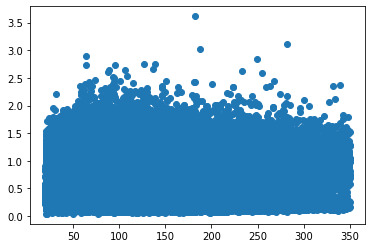

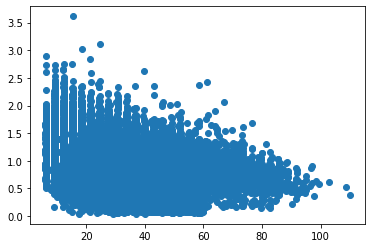

In [4]:
# 1. show correlation between a_max and distance
# 2. show correlation between a_max and duration

with DatabaseConnection() as cur:
    cur.execute("""select seg_id, max(accel), sum(dist), sum(duration) from accels where type='a' group by seg_id having sum(dist)<350 and sum(dist)>20""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['seg_id', 'a_max', 'distance', 'duration'])
    plt.scatter(df.distance, df.a_max)
    plt.show()
    plt.scatter(df.duration, df.a_max)
    plt.show()

    #plt.savefig("images/acc_distance.png", bbox_inches='tight')

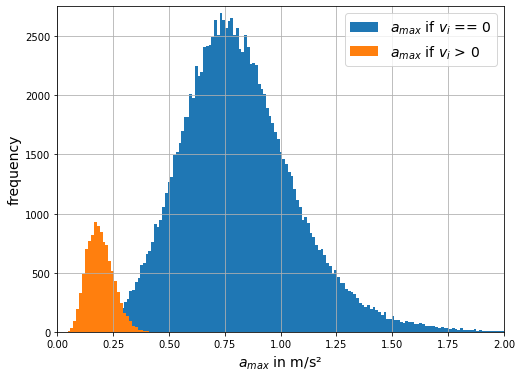

In [18]:
# show 2 groups of a_max

with DatabaseConnection() as cur:
    cur.execute("""select seg_id, max(accel), sum(duration), sum(dist) from accels where type='a' group by seg_id having max(accel) < 2 and sum(dist)<350  and sum(dist)>20 and min(velo) = 0""")
    res = cur.fetchall()
    cur.execute("""select seg_id, max(accel), sum(duration), sum(dist) from accels where type='a' group by seg_id having max(accel) < 2 and sum(dist)<350 and sum(dist)>20 and min(velo) > 0""")
    res2 = cur.fetchall()
    df = pd.DataFrame(res, columns=['seg_id', 'max_a', 'duration', 'distance'])
    df2 = pd.DataFrame(res2, columns=['seg_id', 'max_a', 'duration', 'distance'])
    plt.figure(figsize=(8,6))
    plt.hist(df.max_a, bins=160, label=r'$a_{max}$' + ' if ' + r'$v_i$' + ' == 0')
    plt.hist(df2.max_a, bins=80, label=r'$a_{max}$' + ' if ' + r'$v_i$' + ' > 0')
    plt.grid()
    plt.xlabel(r'$a_{max}$ in m/s²', fontsize=14)
    plt.ylabel('frequency', fontsize=14)
    plt.xlim(0, 2)
    plt.ylim(0, 2750)
    plt.legend(fontsize=14)
    plt.savefig("images/acc_max_all_split_title.png", bbox_inches='tight')


0.2819574718894465
0.3014981834033237


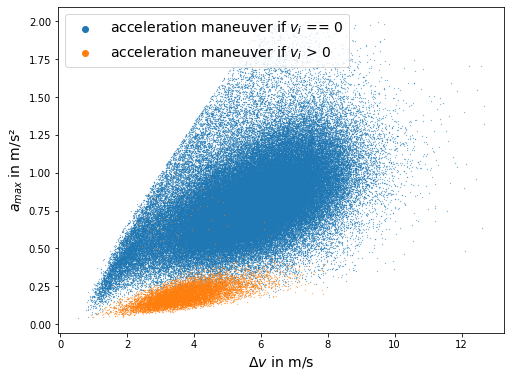

In [19]:
# Show correlation between a_max and |v_i - v_f|

from scipy.stats import linregress

with DatabaseConnection() as cur:
    cur.execute("""select seg_id, max(velo), min(velo), max(accel), max(velo) - min(velo) from accels where type = 'a' group by seg_id having max(accel)<2 and sum(dist)>20 and sum(dist)<350 and min(velo) = 0""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['seg_id','max_v', 'min_v', 'max_a', 'delta_velo'])
    df['ln_max_a'] = df.apply(lambda x: math.log(x['max_a']), axis = 1) 
    df['ln_delta_velo'] = df.apply(lambda x: math.log(x['delta_velo']), axis = 1) 

    cur.execute("""select seg_id, max(velo), min(velo), max(accel), max(velo) - min(velo) from accels where type = 'a' group by seg_id having max(accel)<2 and sum(dist)>20 and sum(dist)<350 and min(velo) > 0""")
    res2 = cur.fetchall()
    df2 = pd.DataFrame(res2, columns=['seg_id','max_v', 'min_v', 'max_a', 'delta_velo'])
    df2['ln_max_a'] = df2.apply(lambda x: math.log(x['max_a']), axis = 1) 
    df2['ln_delta_velo'] = df2.apply(lambda x: math.log(x['delta_velo']), axis = 1) 
    
    slope, intercept, r_value, p_value, std_err = linregress(df.delta_velo, df.max_a)
    slope2, intercept2, r_value2, p_value2, std_err2 = linregress(df2.delta_velo, df2.max_a)

    plt.figure(figsize=(8,6))

    plt.scatter(df.delta_velo, df.max_a, marker='.', s=0.2,)
    plt.scatter(df2.delta_velo, df2.max_a, marker='.', s=0.2)
    plt.scatter([], [], color=u'#1f77b4', label='acceleration maneuver if ' + r'$v_i$' + ' == 0')
    plt.scatter([], [], color=u'#ff7f0e', label='acceleration maneuver if ' + r'$v_i$' + ' > 0')
    plt.xlabel(r'$\Delta v$ in m/s', fontsize=14)
    plt.ylabel(r'$a_{max}$ in m/s²', fontsize=14)
    plt.legend(fontsize=14)
    plt.savefig("images/acc_delta_velo_vs_max_a_title.png", bbox_inches='tight')

print(r_value**2)
print(r_value2**2)

0.35259524019486155
0.4191474146374655


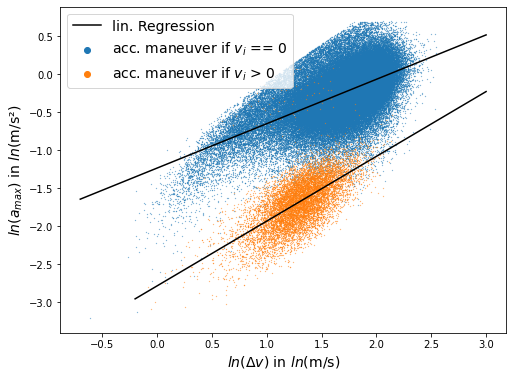

In [20]:
# Show correlation between ln(a_max) and ln(|v_i - v_f|)

with DatabaseConnection() as cur:
    cur.execute("""select seg_id, max(velo), min(velo), max(accel), max(velo) - min(velo) from accels where type = 'a' group by seg_id having max(accel)<2 and sum(dist)>20 and sum(dist)<350 and min(velo) = 0""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['seg_id','max_v', 'min_v', 'max_a', 'delta_velo'])
    df['ln_max_a'] = df.apply(lambda x: math.log(x['max_a']), axis = 1) 
    df['ln_delta_velo'] = df.apply(lambda x: math.log(x['delta_velo']), axis = 1) 

    cur.execute("""select seg_id, max(velo), min(velo), max(accel), max(velo) - min(velo) from accels where type = 'a' group by seg_id having max(accel)<2 and sum(dist)>20 and sum(dist)<350 and min(velo) > 0""")
    res2 = cur.fetchall()
    df2 = pd.DataFrame(res2, columns=['seg_id','max_v', 'min_v', 'max_a', 'delta_velo'])
    df2['ln_max_a'] = df2.apply(lambda x: math.log(x['max_a']), axis = 1) 
    df2['ln_delta_velo'] = df2.apply(lambda x: math.log(x['delta_velo']), axis = 1) 


    slope, intercept, r_value, p_value, std_err = linregress(df.ln_delta_velo, df.ln_max_a)
    slope2, intercept2, r_value2, p_value2, std_err2 = linregress(df2.ln_delta_velo, df2.ln_max_a)

    plt.figure(figsize=(8,6))

    plt.scatter(df.ln_delta_velo, df.ln_max_a, s=0.2, marker='.')
    plt.scatter(df2.ln_delta_velo, df2.ln_max_a, s=0.2, marker='.')

    #plt.hist2d(df.ln_delta_velo, df.ln_max_a, bins=140)

    plt.scatter([], [], color=u'#1f77b4', label='acc. maneuver if ' + r'$v_i$' + ' == 0')
    plt.scatter([], [], color=u'#ff7f0e', label='acc. maneuver if ' + r'$v_i$' + ' > 0')
    plt.plot([-0.7, 3], [intercept + slope*-0.7, intercept + slope*3], c='black', label='lin. Regression')
    plt.plot([-0.2, 3], [intercept2 + slope2*-0.2, intercept2 + slope2*3], c='black')
    plt.xlabel(r'$ln(\Delta v)$ in $ln$(m/s)', fontsize=14)
    plt.ylabel(r'$ln(a_{max})$ in $ln$(m/s²)', fontsize=14)
    plt.legend(fontsize=14, loc='upper left')
    plt.savefig("images/acc_ln_delta_velo_vs_ln_max_a.png", bbox_inches='tight')

print(r_value**2)
print(r_value2**2)

In [16]:
# plot representative Acc maneuvers

from scipy.interpolate import make_interp_spline, BSpline

def plot_accels(x, one_plot):
    
    x['cum_duration'] = x.duration.cumsum()

    x = x[~x.a.isnull()]

    xnew = np.linspace(x.cum_duration.min(), x.cum_duration.max(), 1000) 
    try:
        spl_a = make_interp_spline(x.cum_duration, x.a)  # type: BSpline
        #spl_v = make_interp_spline(x.cum_duration, x.velo)  # type: BSpline
        smooth_a = spl_a(xnew)
        #smooth_v = spl_v(xnew)
    except: 
        return
    
    plt.figure(figsize=(8,6))

    plt.plot(xnew, smooth_a, label='acceleration')
    plt.scatter(x.cum_duration, x.a)

    plt.xlabel('duration in seconds', fontsize=14)
    plt.ylabel('acceleration in m/s²', fontsize=14)
    plt.legend(fontsize=14)

    #plt.plot(xnew, smooth_v)
    #plt.scatter(x.cum_duration, x.velo)
    plt.savefig('images/acc_processes/%i'%x.seg_id.values[0], bbox_inches='tight')
    plt.show()
    

with DatabaseConnection() as cur:
    cur.execute("""select seg_id, accel, duration, velo from accels where type = 'a' Limit 50""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['seg_id','a', 'duration', 'velo'])
    df.groupby('seg_id', as_index=False).apply(lambda x: plot_accels(x, False))

0.8118711354581246
0.9836621033297228 0.6281955209727766 0.1867253837065674
0.4274885331550032
1.2730027281676768
0.9258797587215066
KstestResult(statistic=0.0019668507969461888, pvalue=0.7121140162739403)


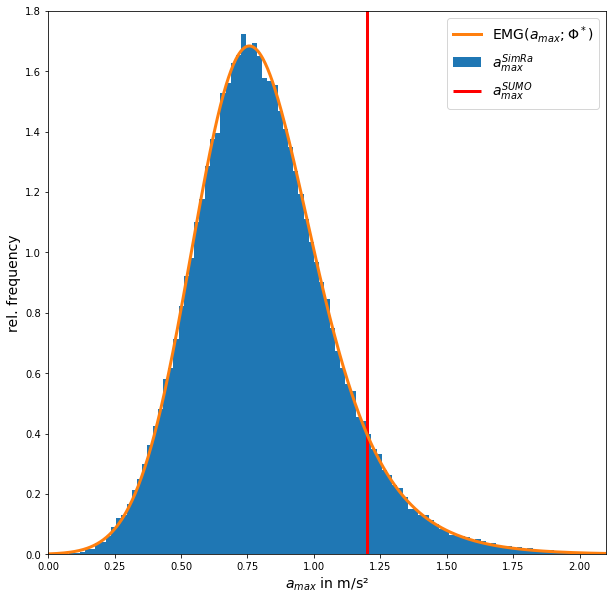

In [22]:
import scipy

colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c']

with DatabaseConnection() as cur:
    cur.execute("""select seg_id, max(accel), sum(duration), sum(dist) from accels where type='a' group by seg_id having max(accel) < 2 and sum(dist)<350 and sum(dist)>20 and min(velo) = 0""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['seg_id', 'max_a', 'duration', 'distance'])
    print(df.max_a.mean())
    plt.figure(figsize=(10,10))

    #df.max_a.hist(bins=120, legend=True)
    plt.hist(df.max_a, bins=100, density=True, alpha=1, color=colors[0], label=r'$a_{max}^{SimRa}$')
    #plt.title('max(a) if initial velo <1m/s')

    mean,std, l = scipy.stats.exponnorm.fit(df.max_a)
    x = np.linspace(0, 3, 1000)
    y = scipy.stats.exponnorm.pdf(x, mean, std, l)
    plt.xlim(0,2.1)
    plt.plot(x, y, c=colors[1], linewidth=3, label='EMG(' + r'$a_{max}; \Phi^*$' + ')')
    plt.xlabel(r'$a_{max}$ in m/s²', fontsize=14)
    plt.ylabel('rel. frequency', fontsize=14)
    plt.vlines(1.2, 0, 4, colors='r', linewidth=3, label=r'$a_{max}^{SUMO}$')
    plt.ylim(0, 1.8)
    plt.legend(fontsize=14)
    plt.savefig('images/max_acceleration_dist_fit', bbox_inches='tight')

print(mean, std, l)
print(scipy.stats.exponnorm(mean, std, l).ppf(0.05))
print(scipy.stats.exponnorm(mean, std, l).ppf(0.95))
print(scipy.stats.exponnorm(mean, std, l).cdf(1.20))
print(scipy.stats.kstest(df.max_a, 'exponnorm', args=(mean, std, l)))

In [23]:
# find best distribution fit for data

list_of_dists = ['alpha','anglit','arcsine','beta','betaprime','bradford','burr','burr12','cauchy','chi','chi2','cosine','dgamma','dweibull','erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk','foldcauchy','foldnorm','frechet_r','frechet_l','genlogistic','genpareto','gennorm','genexpon','genextreme','gausshyper','gamma','gengamma','genhalflogistic','gilbrat','gompertz','gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l','logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke','nakagami','ncx2','ncf','nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','reciprocal','rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm','tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max']

results=[]
for i in list_of_dists:
    dist = getattr(scipy.stats, i)
    param = dist.fit(df.max_a)
    a = scipy.stats.kstest(df.max_a, i, args=param)
    results.append((i,a[0],a[1]))
    
    
results.sort(key=lambda x:float(x[2]), reverse=True)
for j in results:
    print("{}: statistic={}, pvalue={}".format(j[0], j[1], j[2]))

exponnorm: statistic=0.0019668507969461888, pvalue=0.7121140162739403
